In [1]:
%load_ext autoreload
%autoreload 2
import torch

In [2]:
import os
os.chdir('../')

In [3]:
from utils.datasets import get_dataloaders, get_img_size, DATASETS
from disvae.utils.modelIO import save_model, load_model, load_metadata


# fit regressor

## load dataset

In [57]:
test_loader = get_dataloaders("ddsprites2",
                              batch_size=128,
                              shuffle=False,
                              logger=None)

## load model

In [58]:
exp_dir = 'cvae_ddsprites2_randSample_klqq=0.1_klu=10_epoch=70_z=7_zu=2'
exp_dir = 'results/' + exp_dir
model = load_model(exp_dir, is_gpu=True)

In [59]:
print(exp_dir)

results/cvae_ddsprites2_randSample_klqq=0.1_klu=10_epoch=70_z=7_zu=2


In [7]:
device = 'cuda'
def infer(model, data):
    with torch.no_grad():
        model.eval()
        device = next(model.parameters()).device

        latents, targets = [], []
        for x, t in data:
            x, xa, xb = x
            x = x.to(device=device)
            xa = xa.to(device=device) 
            xb = xb.to(device=device)

            pmu1, plu1, pmc1, plc1, pmu2, plu2, _, _ = model.encoder(xa, xb)
            post_mean = torch.cat((pmu1, pmc1, pmu2), dim=-1) # just using the mean from xa
            latents.append(post_mean.cpu())
            targets.append(t)

    latents = torch.cat(latents)
    targets = torch.cat(targets)

    return latents, targets

In [61]:
l, t = infer(model, test_loader)

In [73]:
from analysis.metrics import DCIMetrics
metric_data = (l, t)
eastwood = DCIMetrics(metric_data, n_factors=6)


In [74]:
print(t.shape)

torch.Size([737280, 6])


In [75]:
print(l.shape)

torch.Size([737280, 7])


In [76]:
vae_scores = eastwood(model, model_zs = metric_data)


[array([0., 0., 0., 0., 0., 0., 0.]), array([0.        , 0.        , 0.        , 0.37016459, 0.        ,
       0.        , 0.        ]), array([0.00000000e+00, 0.00000000e+00, 1.45349995e-04, 8.43019925e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), array([0.        , 0.01978629, 0.        , 0.        , 0.13418185,
       0.00866528, 0.        ]), array([0.        , 0.95493139, 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([0.95695269, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.56952687e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.97862936e-02
  9.54931386e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.45349995e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.70164593e-01 8.43019925e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.34181

In [77]:
vae_R = vae_scores.R_coeff

## visualizing

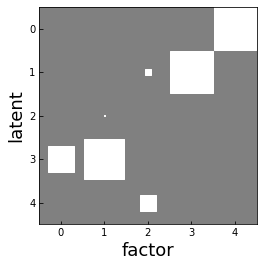

In [83]:
from analysis.hinton import hinton
hinton(vae_R[:5, 1:], 'factor', 'latent', fontsize=18)

In [79]:
print(vae_R.shape)

(7, 6)


In [81]:
print(vae_scores.disentanglement_scores)

[1.         0.94463404 1.         0.65668455 1.         1.
 1.        ]


## new exp 3d-shapes

In [5]:
test_loader = get_dataloaders("dshapes2",
                              batch_size=128,
                              shuffle=False,
                              logger=None)
exp_dir = 'cvae_dshapes2_randSample_klqq=0.1_klu=10_epoch=70_batch=32_z=7_zu=1'
exp_dir = 'results/' + exp_dir
model = load_model(exp_dir, is_gpu=True)

In [8]:
l, t = infer(model, test_loader)

In [24]:
from analysis.metrics import DCIMetrics
metric_data = (l[:,:6], t)
eastwood = DCIMetrics(metric_data, n_factors=6)

In [25]:
vae_scores = eastwood(model, model_zs = metric_data)
vae_R = vae_scores.R_coeff

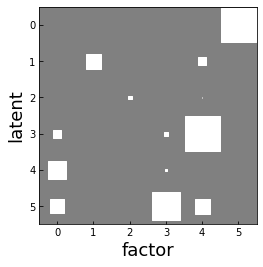

In [26]:
from analysis.hinton import hinton
hinton(vae_R, 'factor', 'latent', fontsize=18)

In [27]:
print(vae_scores.disentanglement_scores)

[1.         0.70023737 0.93821185 0.85113669 0.95553696 0.49920984]


In [28]:
print(vae_scores.overall_disentanglment)

0.7925896979212347


In [16]:
print(vae_R)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.13894131e-01]
 [0.00000000e+00 1.74199145e-01 0.00000000e+00 0.00000000e+00
  5.15097845e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.08848454e-02 0.00000000e+00
  2.60105544e-04 0.00000000e+00]
 [4.81733732e-02 0.00000000e+00 0.00000000e+00 1.38038315e-02
  9.37402693e-01 0.00000000e+00]
 [2.41154866e-01 0.00000000e+00 0.00000000e+00 3.77611552e-03
  0.00000000e+00 0.00000000e+00]
 [1.54128355e-01 0.00000000e+00 0.00000000e+00 5.90074644e-01
  1.71997119e-01 0.00000000e+00]]


## Action Exp

In [4]:
test_loader = get_dataloaders("dshapesd",
                              batch_size=128,
                              shuffle=False,
                              logger=None)

In [5]:
exp_dir = 'avae_actpost_beta=8_klqq=0.0_dshapesd_fb=0_epoch=30_z=10_lr=0.0001_batch=64_seed=0'
exp_dir = 'results/' + exp_dir
model = load_model(exp_dir, is_gpu=True)

In [8]:
device = 'cuda'
def infer(model, data):
    with torch.no_grad():
        model.eval()
        device = next(model.parameters()).device

        latents, targets = [], []
        for x, t in data:
            x, xa, xb = x
            x = x.to(device=device)
            xa = xa.to(device=device) 
            xb = xb.to(device=device)

            post_mean, post_logvar, _, _, _, _ = model.encoder(xa, xb)
            latents.append(post_mean.cpu())
            targets.append(t[0])

    latents = torch.cat(latents)
    targets = torch.cat(targets)

    return latents, targets

In [9]:
l, t = infer(model, test_loader)

In [10]:
from analysis.metrics import DCIMetrics
metric_data = (l, t)
eastwood = DCIMetrics(metric_data, n_factors=6)

In [11]:
vae_scores = eastwood(model, model_zs = metric_data)
vae_R = vae_scores.R_coeff

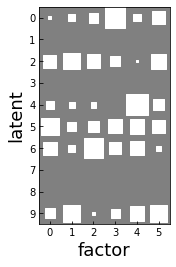

In [12]:
from analysis.hinton import hinton
hinton(vae_R, 'factor', 'latent', fontsize=18)

In [13]:
print(vae_scores.overall_disentanglment)

0.17086579308197275


## batch 32

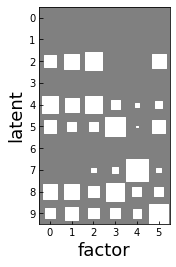

In [19]:
from analysis.metrics import DCIMetrics
from analysis.hinton import hinton

exp_dir = 'avae_actpost_beta=8_klqq=0.0_dshapesd_fb=0_epoch=30_z=10_lr=0.0001_batch=32_seed=0'
exp_dir = 'results/' + exp_dir
model = load_model(exp_dir, is_gpu=True)
l, t = infer(model, test_loader)
metric_data = (l, t)
eastwood = DCIMetrics(metric_data, n_factors=6)
vae_scores = eastwood(model, model_zs = metric_data)
vae_R = vae_scores.R_coeff
hinton(vae_R, 'factor', 'latent', fontsize=18)

In [20]:
print(vae_scores.overall_disentanglment)

0.21069463629022628


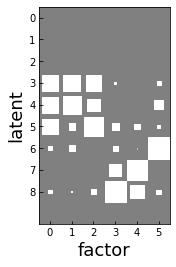

In [17]:
from analysis.metrics import DCIMetrics
from analysis.hinton import hinton

exp_dir = 'avae_actpost_beta=16_klqq=0.0_dshapesd_fb=0_epoch=30_z=10_lr=0.0001_batch=32_seed=0'
exp_dir = 'results/' + exp_dir
model = load_model(exp_dir, is_gpu=True)
l, t = infer(model, test_loader)
metric_data = (l, t)
eastwood = DCIMetrics(metric_data, n_factors=6)
vae_scores = eastwood(model, model_zs = metric_data)
vae_R = vae_scores.R_coeff
hinton(vae_R, 'factor', 'latent', fontsize=18)

In [18]:
print(vae_scores.overall_disentanglment)

0.4412515536844073


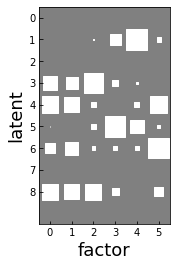

In [21]:
from analysis.metrics import DCIMetrics
from analysis.hinton import hinton

exp_dir = 'avae_actpost_beta=16_klqq=0.0_dshapesd_fb=0_epoch=30_z=10_lr=0.0001_batch=64_seed=0'
exp_dir = 'results/' + exp_dir
model = load_model(exp_dir, is_gpu=True)
l, t = infer(model, test_loader)
metric_data = (l, t)
eastwood = DCIMetrics(metric_data, n_factors=6)
vae_scores = eastwood(model, model_zs = metric_data)
vae_R = vae_scores.R_coeff
hinton(vae_R, 'factor', 'latent', fontsize=18)

In [22]:
print(vae_scores.overall_disentanglment)

0.36921277389506457


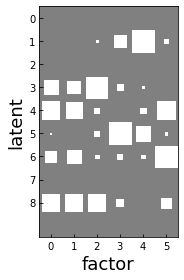

In [30]:
from analysis.hinton import hinton
hinton(vae_R, 'factor', 'latent', fontsize=18, save_plot=True, figs_dir=exp_dir)
